In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
%matplotlib inline

Clean up the notebook

In [46]:
import os

original_file_path = "collegiate_athlete_injury_dataset.csv"
processed_file_path = f'processed_{original_file_path}'
path = './'

if os.path.exists(f'{path}{processed_file_path}'):
    os.remove(f'{path}{processed_file_path}')

Review data

In [47]:
df = pd.read_csv(original_file_path)
df.dtypes


Athlete_ID                  object
Age                          int64
Gender                      object
Height_cm                    int64
Weight_kg                    int64
Position                    object
Training_Intensity           int64
Training_Hours_Per_Week      int64
Recovery_Days_Per_Week       int64
Match_Count_Per_Week         int64
Rest_Between_Events_Days     int64
Fatigue_Score                int64
Performance_Score            int64
Team_Contribution_Score      int64
Load_Balance_Score           int64
ACL_Risk_Score               int64
Injury_Indicator             int64
dtype: object

<!-- Preprocess the data in the csv -->

In [48]:
# Check for nan
# null_counts = df.isna().sum()
# print(null_counts)

# Drop useless column
df_processed = df.drop('Athlete_ID', axis=1)


# Convert to imperial system
df_processed['height'] = np.floor(df_processed['Height_cm'].divide(2.54))
df_processed = df_processed.drop('Height_cm', axis=1)

df_processed['weight'] = np.floor(df_processed['Weight_kg'].multiply(2.205))
df_processed = df_processed.drop('Weight_kg', axis=1)

df_processed = pd.get_dummies(df_processed)

# get_dummies drops the original columns
df_processed.columns = [x.lower() for x in df_processed.columns]
y = df_processed['injury_indicator']
df_processed = df_processed.drop('injury_indicator', axis=1)
numeric_columns =  df_processed.select_dtypes(include=['int', 'float']).columns
scaler = StandardScaler()
df_processed[numeric_columns]  = scaler.fit_transform(df_processed[numeric_columns] )
 
df_processed.head() 

,age,training_intensity,training_hours_per_week,recovery_days_per_week,match_count_per_week,rest_between_events_days,fatigue_score,performance_score,team_contribution_score,load_balance_score,acl_risk_score,height,weight,gender_female,gender_male,position_center,position_forward,position_guard
0,1.416577,-1.245595,0.380547,0.018537,0.533920,-1.196184,-1.534767,1.680445,-1.016210,0.764573,-2.247502,1.166200,1.739734,True,False,True,False,False
1,-0.085095,1.161352,0.606390,-1.217279,0.533920,-1.196184,-0.360200,-1.333192,-0.668906,-1.203291,1.403961,0.947195,-0.997706,False,True,False,True,False
2,0.415462,1.161352,-0.748672,0.018537,-1.202406,1.257527,0.422844,-1.127717,-0.738367,0.764573,0.821844,-1.461857,0.462262,False,True,False,False,True
3,1.416577,-1.646753,0.380547,-1.217279,-1.202406,-1.196184,0.814366,0.516085,0.095161,-1.782075,0.239726,0.947195,1.009750,True,False,False,False,True
4,-0.585652,-0.844437,-0.522828,-1.217279,-0.334243,-1.196184,-1.143245,1.064019,-1.502434,-1.203291,0.133887,-0.585838,0.133770,True,False,True,False,False


Review column correlation

In [49]:
df_processed.corr('pearson')
# There doesn't seem to be any columns that have a substantive correlation

,age,training_intensity,training_hours_per_week,recovery_days_per_week,match_count_per_week,rest_between_events_days,fatigue_score,performance_score,team_contribution_score,load_balance_score,acl_risk_score,height,weight,gender_female,gender_male,position_center,position_forward,position_guard
age,1.000000,0.046616,-0.082926,-0.060282,0.073681,0.002610,0.062439,0.007918,-0.059180,0.097219,-0.021586,-0.018061,-0.021046,0.029154,-0.029154,-0.022462,-0.083432,0.107950
training_intensity,0.046616,1.000000,-0.020210,-0.076062,-0.118560,0.082499,-0.004178,-0.130479,0.059598,-0.052542,0.361971,-0.063772,-0.041000,-0.149738,0.149738,0.187990,-0.127630,-0.058994
training_hours_per_week,-0.082926,-0.020210,1.000000,0.121332,0.025239,-0.256886,0.005765,0.077861,-0.013388,-0.511471,0.208818,0.055761,-0.119447,0.007460,-0.007460,-0.064336,-0.085348,0.152119
recovery_days_per_week,-0.060282,-0.076062,0.121332,1.000000,0.049112,-0.053634,-0.036869,-0.025226,-0.013782,0.525141,-0.303318,0.101527,-0.034731,-0.042059,0.042059,-0.026413,-0.012307,0.039209
match_count_per_week,0.073681,-0.118560,0.025239,0.049112,1.000000,-0.069632,-0.030320,0.068142,-0.011008,0.019891,-0.033123,0.006678,0.090975,0.067927,-0.067927,-0.105333,0.018657,0.087100
rest_between_events_days,0.002610,0.082499,-0.256886,-0.053634,-0.069632,1.000000,-0.065807,-0.094817,0.086560,0.111465,-0.053774,0.044837,-0.013283,0.118990,-0.118990,0.008480,-0.157546,0.152543
fatigue_score,0.062439,-0.004178,0.005765,-0.036869,-0.030320,-0.065807,1.000000,-0.051428,0.080237,-0.113004,0.649706,-0.025809,-0.041487,-0.119472,0.119472,-0.061283,-0.075519,0.138991
performance_score,0.007918,-0.130479,0.077861,-0.025226,0.068142,-0.094817,-0.051428,1.000000,-0.023421,-0.086528,-0.026019,0.010817,-0.083711,0.125130,-0.125130,-0.087171,-0.034140,0.122778
team_contribution_score,-0.059180,0.059598,-0.013388,-0.013782,-0.011008,0.086560,0.080237,-0.023421,1.000000,-0.039470,0.123173,-0.062450,-0.061609,-0.108214,0.108214,-0.000428,-0.120217,0.123353
load_balance_score,0.097219,-0.052542,-0.511471,0.525141,0.019891,0.111465,-0.113004,-0.086528,-0.039470,1.000000,-0.568265,-0.003590,0.005863,-0.038601,0.038601,0.008530,0.098715,-0.109534


<!-- Preprocess the data in the csv -->

<!-- Preprocess the data in the csv -->

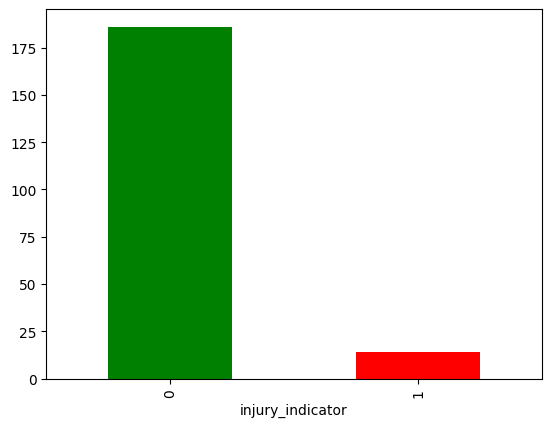

In [50]:
# Check target column distribution
y.value_counts().plot.bar(color=['green', 'red']);

# As expected there is an imbalance with those with and without the injury


In [51]:
# y_values = df['injury_indicator'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(df_processed, y, test_size=0.3)

In [52]:
lr = LogisticRegression(penalty='l2',max_iter=10000)
lr.fit(X_train, y_train)
y_hat = lr.predict(X_test)
print(accuracy_score(y_test, y_hat))
print(precision_score(y_test, y_hat))
print(recall_score(y_test, y_hat))

0.9333333333333333
0.5
0.25


<Axes: xlabel='injury_indicator'>

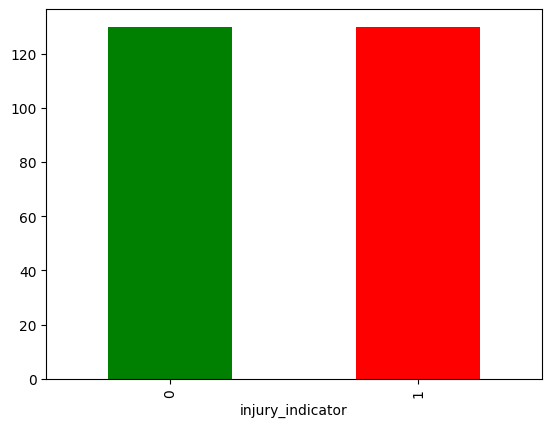

In [53]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
smote_sampler = SMOTE() 
X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)
y_smo.value_counts().plot.bar(color=['green', 'red'])

In [54]:
lr_smote = LogisticRegression(penalty='l2',max_iter=10000)
lr_smote.fit(X_smo, y_smo)
y_hat_smote = lr_smote.predict(X_test)


In [55]:
print(accuracy_score(y_test, y_hat_smote))
print(precision_score(y_test, y_hat_smote))
print(recall_score(y_test, y_hat_smote))
print(f1_score(y_test, y_hat_smote))

0.9333333333333333
0.5
0.5
0.5
